In [2]:
% pylab inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import warnings
import pickle

pd.options.display.float_format = '{:.2f}'.format
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


In [3]:
# Load data set
df = pickle.load(open('df.pkl','rb'))
print(df.head())

            date_block_num  shop_id  item_id  item_price  item_cnt_day  \
date                                                                     
2013-01-01               0        2     1905      249.00          1.00   
2013-01-01               0       14     1905      249.00          1.00   
2013-01-01               0       46     1830      599.00          3.00   
2013-01-01               0       19    22088       79.00          2.00   
2013-01-01               0       37    22088       79.00          4.00   

            item_category_id  
date                          
2013-01-01                30  
2013-01-01                30  
2013-01-01                30  
2013-01-01                83  
2013-01-01                83  


In [4]:
# Create dataframe dictionary of top 50 best selling items
DataFrameDict = {elem : pd.DataFrame for elem in df.item_id.unique()}

last_day = pd.DataFrame(index=['2015-10-31'])

for key in DataFrameDict.keys():
    DataFrameDict[key] = df[:][df.item_id == key]
    DataFrameDict[key] = DataFrameDict[key].groupby(['date'])['item_cnt_day'].sum().sort_index()
    DataFrameDict[key] = DataFrameDict[key].reset_index()
    DataFrameDict[key].index = DataFrameDict[key]['date']
    DataFrameDict[key] = DataFrameDict[key].drop('date', axis=1)
    pd.to_datetime(DataFrameDict[key].index)    
    if '2015-10-31' in DataFrameDict[key].index:
        pass
    else: 
        DataFrameDict[key] = DataFrameDict[key].append(last_day)
    DataFrameDict[key] = DataFrameDict[key].asfreq('D').fillna(0)
    print(DataFrameDict[key].tail(1))

            item_cnt_day
date                    
2015-10-31          2.00
            item_cnt_day
2015-10-31          0.00
            item_cnt_day
date                    
2015-10-31         15.00
            item_cnt_day
2015-10-31          0.00
            item_cnt_day
date                    
2015-10-31          2.00
            item_cnt_day
2015-10-31          0.00
            item_cnt_day
date                    
2015-10-31          6.00
            item_cnt_day
2015-10-31          0.00
            item_cnt_day
date                    
2015-10-31         11.00
            item_cnt_day
date                    
2015-10-31         10.00
            item_cnt_day
2015-10-31          0.00
            item_cnt_day
date                    
2015-10-31         28.00
            item_cnt_day
date                    
2015-10-31          2.00
            item_cnt_day
date                    
2015-10-31          1.00
            item_cnt_day
date                    
2015-10-31          7.00


In [6]:
total_annaul_data = {elem : pd.DataFrame for elem in df.item_id.unique()}
total_annaul_train = {elem : pd.DataFrame for elem in df.item_id.unique()}
total_annaul_test = {elem : pd.DataFrame for elem in df.item_id.unique()}

for key in total_annaul_data.keys():
    total_annaul_data[key] = DataFrameDict[key].resample('M').sum()
    total_annaul_train[key] = total_annaul_data[key]['item_cnt_day'][:-1]
    total_annaul_test[key] = total_annaul_data[key]['item_cnt_day'][-1:]

In [5]:
%%time 
# grid search sarima hyperparameters
from math import sqrt
from multiprocessing import cpu_count
from joblib import Parallel
from joblib import delayed
from warnings import catch_warnings
from warnings import filterwarnings
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
 
# one-step sarima forecast
def sarima_forecast(history, config):
    order, sorder, trend = config
    # define model
    model = SARIMAX(history, order=order, seasonal_order=sorder, trend=trend, enforce_stationarity=False, enforce_invertibility=False)
    # fit model
    model_fit = model.fit(disp=False)
    # make one step forecast
    yhat = model_fit.predict(len(history), len(history))
    return yhat[0]
 
# mean absolute error or mae
def measure_mae(actual, predicted):
    return mean(abs(actual - predicted))
 
# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
    return data[:-n_test], data[-n_test:]
 
# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg):
    predictions = list()
    # split dataset
    train, test = train_test_split(data, n_test)
    # seed history with training dataset
    history = [x for x in train]
    # step over each time-step in the test set
    for i in range(len(test)):
        # fit model and make forecast for history
        yhat = sarima_forecast(history, cfg)
        # store forecast in list of predictions
        predictions.append(yhat)
        # add actual observation to history for the next loop
        history.append(test[i])
    # estimate prediction error
    error = measure_mae(test, predictions)
    return error
 
# score a model, return None on failure
def score_model(data, n_test, cfg, debug=False):
    result = None
    # convert config to a key
    key = str(cfg)
    # show all warnings and fail on exception if debugging
    if debug:
        result = walk_forward_validation(data, n_test, cfg)
    else:
        # one failure during model validation suggests an unstable config
        try:
            # never show warnings when grid searching, too noisy
            with catch_warnings():
                filterwarnings("ignore")
                result = walk_forward_validation(data, n_test, cfg)
        except:
            error = None
    # check for an interesting result
    #if result is not None:
        #print(' > Model[%s] %.3f' % (key, result))
    return (key, result)
 
# grid search configs
def grid_search(data, cfg_list, n_test, parallel=True):
    scores = None
    if parallel:
        # execute configs in parallel
        executor = Parallel(n_jobs=cpu_count(), backend='multiprocessing')
        tasks = (delayed(score_model)(data, n_test, cfg) for cfg in cfg_list)
        scores = executor(tasks)
    else:
        scores = [score_model(data, n_test, cfg) for cfg in cfg_list]
    # remove empty results
    scores = [r for r in scores if r[1] != None]
    # sort configs by error, asc
    scores.sort(key=lambda tup: tup[1])
    return scores
 
# create a set of sarima configs to try
def sarima_configs(seasonal=[0]):
    models = list()
    # define config lists
    p_params = [0, 1, 2]
    d_params = [0, 1]
    q_params = [0, 1, 2]
    t_params = ['n','c','t','ct']
    P_params = [0, 1, 2]
    D_params = [0, 1]
    Q_params = [0, 1, 2]
    m_params = seasonal
    # create config instances
    for p in p_params:
        for d in d_params:
            for q in q_params:
                for t in t_params:
                    for P in P_params:
                        for D in D_params:
                            for Q in Q_params:
                                for m in m_params:
                                    cfg = [(p,d,q), (P,D,Q,m), t]
                                    models.append(cfg)
    return models

top_model = {elem : pd.DataFrame for elem in total_annaul_train.keys()}

for key in total_annaul_train.keys():
    if __name__ == '__main__':
        # define dataset
        data = total_annaul_train[key]
        # data split
        n_test = 3
        # model configs
        cfg_list = sarima_configs(seasonal=[0, 12])
        # grid search
        scores = grid_search(data, cfg_list, n_test)
        top_model[key] = scores[0][0]
        # list top 3 configs
        print(key, 'done')
        for cfg, error in scores[:3]:
            print(' > Model[%s] %.3f' % (cfg, error))

1905 done
 > Model[[(1, 1, 0), (1, 0, 0, 12), 'ct']] 2.160
 > Model[[(1, 1, 2), (1, 0, 0, 12), 'ct']] 2.545
 > Model[[(2, 1, 0), (1, 0, 0, 12), 'ct']] 2.921
1830 done
 > Model[[(0, 0, 0), (0, 0, 1, 0), 'n']] 1.422
 > Model[[(0, 0, 1), (0, 0, 0, 0), 'n']] 1.422
 > Model[[(0, 0, 1), (0, 0, 0, 12), 'n']] 1.422
22088 done
 > Model[[(1, 1, 2), (0, 1, 0, 12), 'ct']] 5.642
 > Model[[(1, 0, 2), (1, 1, 0, 12), 't']] 6.176
 > Model[[(0, 0, 0), (2, 0, 2, 0), 'c']] 6.818
2416 done
 > Model[[(0, 0, 2), (0, 0, 2, 0), 'n']] 7.427
 > Model[[(1, 0, 0), (1, 0, 0, 0), 'n']] 9.437
 > Model[[(0, 0, 0), (0, 0, 0, 0), 'n']] 10.000
2808 done
 > Model[[(1, 0, 0), (1, 0, 1, 0), 't']] 5.292
 > Model[[(2, 0, 1), (0, 0, 0, 0), 't']] 5.476
 > Model[[(2, 0, 1), (0, 0, 0, 12), 't']] 5.476
6740 done
 > Model[[(0, 0, 2), (1, 0, 0, 0), 'ct']] 1.306
 > Model[[(2, 0, 0), (0, 0, 2, 0), 'ct']] 1.312
 > Model[[(0, 1, 0), (1, 0, 0, 12), 'c']] 1.413
2308 done
 > Model[[(2, 1, 1), (1, 1, 0, 12), 't']] 26.340
 > Model[[(0, 0, 2)

In [9]:
pickle.dump(top_model, open('top_model_SARIMAX.pkl','wb'))

In [10]:
top_model

{1495: "[(0, 1, 1), (2, 0, 0, 0), 'ct']",
 1830: "[(0, 0, 0), (0, 0, 1, 0), 'n']",
 1855: "[(2, 0, 2), (2, 0, 2, 0), 'n']",
 1905: "[(1, 1, 2), (1, 0, 0, 12), 'ct']",
 1916: "[(2, 1, 1), (2, 0, 2, 0), 't']",
 2269: "[(2, 1, 0), (1, 0, 0, 12), 'n']",
 2308: "[(2, 1, 1), (1, 1, 0, 12), 't']",
 2416: "[(0, 0, 2), (0, 0, 2, 0), 'n']",
 2445: "[(0, 0, 0), (1, 0, 2, 0), 't']",
 2753: "[(2, 0, 0), (2, 0, 0, 12), 'c']",
 2808: "[(1, 0, 0), (1, 0, 1, 0), 't']",
 3329: "[(0, 0, 2), (1, 0, 0, 0), 'n']",
 3331: "[(2, 0, 0), (2, 0, 2, 0), 'c']",
 3340: "[(0, 1, 0), (0, 0, 2, 0), 'n']",
 3341: "[(1, 0, 0), (1, 0, 0, 0), 'c']",
 3343: "[(2, 0, 1), (0, 0, 1, 0), 't']",
 3731: "[(1, 1, 0), (0, 0, 0, 0), 'ct']",
 3732: "[(1, 1, 2), (2, 0, 1, 0), 'n']",
 3733: "[(1, 0, 0), (1, 0, 2, 0), 'c']",
 3734: "[(2, 0, 2), (2, 0, 0, 0), 'ct']",
 3928: "[(0, 1, 2), (1, 0, 0, 12), 'ct']",
 4178: "[(1, 1, 0), (2, 0, 2, 0), 'n']",
 4181: "[(0, 0, 0), (0, 0, 2, 0), 'ct']",
 4870: "[(2, 1, 1), (2, 0, 2, 0), 'ct']",
 527

In [11]:
#Store model information into dictionaries for model prediction
import re

#(p,d,q), (P,D,Q,m)
order_term = {elem : pd.DataFrame for elem in top_model.keys()}
sorder_term = {elem : pd.DataFrame for elem in top_model.keys()}
t_term = {elem : pd.DataFrame for elem in top_model.keys()}
trend_seek = re.compile('[a-z]{1,2}')

for key in top_model.keys():
    order_term[key] = (int(top_model[key][2]),int(top_model[key][5]),int(top_model[key][8]))
    sorder_term[key] = (int(top_model[key][13]),int(top_model[key][16]),int(top_model[key][19]),int(top_model[key][22]))
    t_term[key] = (trend_seek.findall(top_model[key]))[0]

In [12]:
print(order_term)
print(sorder_term)
print(t_term)

{5823: (1, 1, 2), 1830: (0, 0, 0), 1905: (1, 1, 2), 2808: (1, 0, 0), 22088: (1, 1, 2), 2308: (2, 1, 1), 6740: (2, 0, 0), 7856: (1, 0, 1), 5822: (2, 0, 2), 17717: (0, 1, 2), 2416: (0, 0, 2), 5272: (1, 0, 0), 7894: (1, 1, 0), 1916: (2, 1, 1), 7893: (1, 0, 0), 5821: (0, 0, 0), 11373: (1, 1, 1), 11370: (0, 0, 0), 2753: (2, 0, 0), 2445: (0, 0, 0), 6457: (0, 0, 1), 6738: (2, 0, 1), 20949: (0, 0, 0), 6497: (2, 1, 0), 15044: (1, 0, 1), 16787: (1, 1, 1), 4870: (2, 1, 1), 4178: (1, 1, 0), 4181: (0, 0, 0), 7096: (1, 1, 0), 3732: (1, 1, 2), 3734: (2, 0, 2), 3329: (0, 0, 2), 3331: (2, 0, 0), 1855: (2, 0, 2), 2269: (2, 1, 0), 1495: (0, 1, 1), 6675: (2, 0, 0), 5672: (0, 0, 2), 7018: (2, 0, 2), 3928: (0, 1, 2), 16790: (2, 1, 1), 6503: (0, 0, 1), 3341: (1, 0, 0), 3343: (2, 0, 1), 3340: (0, 1, 0), 3733: (1, 0, 0), 3731: (1, 1, 0), 10209: (1, 0, 0), 10210: (1, 0, 0)}
{5823: (1, 0, 1, 0), 1830: (0, 0, 1, 0), 1905: (1, 0, 0, 1), 2808: (1, 0, 1, 0), 22088: (0, 1, 0, 1), 2308: (1, 1, 0, 1), 6740: (0, 0, 2, 0

In [13]:
from math import sqrt
from multiprocessing import cpu_count
from joblib import Parallel
from joblib import delayed
from warnings import catch_warnings
from warnings import filterwarnings
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error

# define model
model = SARIMAX(total_annaul_train[20949], order=order_term[20949], seasonal_order=sorder_term[20949], trend=t_term[20949], enforce_stationarity=False, enforce_invertibility=False)
# fit model
model_fit = model.fit(disp=False)
# make one step forecast
yhat = model_fit.predict('2015-10-31')
print(yhat)

2015-10-31   3423.93
Freq: M, dtype: float64


Absolute Error = 638.074


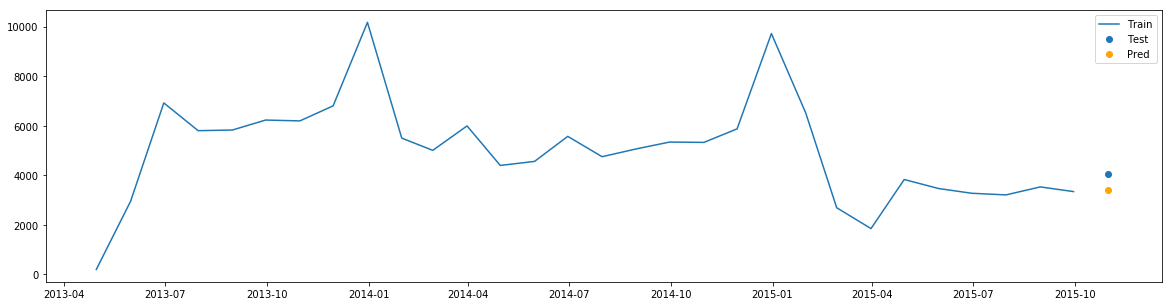

In [14]:
print('Absolute Error = %.3f' % abs(total_annaul_test[20949] - yhat))

plt.figure(figsize=(20,5))
plt.plot(total_annaul_train[20949], label='Train')
plt.scatter(total_annaul_test[20949].index,total_annaul_test[20949], label='Test')
plt.scatter(yhat.index, yhat, label='Pred', color='orange')
plt.legend(loc='best')
plt.show()

In [15]:
%%time
df_pred = pd.DataFrame(index=['Prediction'], columns=None)

for key in total_annaul_train.keys():
    # define model
    model = SARIMAX(total_annaul_train[key], order=order_term[key], seasonal_order=sorder_term[key], trend=t_term[key], enforce_stationarity=False, enforce_invertibility=False)
    # fit model
    model_fit = model.fit(disp=False)
    # make one step forecast
    yhat = model_fit.predict('2015-10-31')
    #df['item_id'].append(key)
    df_pred[key] = yhat[0]
    print(key, yhat)

1905 2015-10-31   18.79
Freq: M, dtype: float64
1830 2015-10-31   1.39
Freq: M, dtype: float64
22088 2015-10-31   124.81
Freq: M, dtype: float64
2416 2015-10-31   20.90
Freq: M, dtype: float64
2808 2015-10-31   -36.77
Freq: M, dtype: float64
6740 2015-10-31   3.38
Freq: M, dtype: float64
2308 2015-10-31   197.23
Freq: M, dtype: float64
1916 2015-10-31   -0.65
Freq: M, dtype: float64
5822 2015-10-31   307.87
Freq: M, dtype: float64
5823 2015-10-31   155.62
Freq: M, dtype: float64
5272 2015-10-31   -1.19
Freq: M, dtype: float64
17717 2015-10-31   477.50
Freq: M, dtype: float64
7856 2015-10-31   51.51
Freq: M, dtype: float64
7894 2015-10-31   57.04
Freq: M, dtype: float64
7893 2015-10-31   81.52
Freq: M, dtype: float64
5821 2015-10-31   159.61
Freq: M, dtype: float64
11373 2015-10-31   390.70
Freq: M, dtype: float64
11370 2015-10-31   258.00
Freq: M, dtype: float64
2753 2015-10-31   100.49
Freq: M, dtype: float64
2445 2015-10-31   110.83
Freq: M, dtype: float64
6457 2015-10-31   42.23
Fre

In [16]:
df_pred

,1905,1830,22088,2416,2808,6740,2308,1916,5822,5823,...,3928,16790,6503,3343,3341,3340,3733,3731,10209,10210
Prediction,18.79,1.39,124.81,20.90,-36.77,3.38,197.23,-0.65,307.87,155.62,...,-5.45,97.36,290.71,306.98,256.78,5.97,76.75,-161.38,-8.01,156.81


In [17]:
df_t = df_pred.T
df_t.head()

,Prediction
1905,18.79
1830,1.39
22088,124.81
2416,20.90
2808,-36.77


In [18]:
df_t = df_t.reset_index().rename(index=str, columns={"index": "item_id"})
df_t.head()

,item_id,Prediction
0,1905,18.79
1,1830,1.39
2,22088,124.81
3,2416,20.90
4,2808,-36.77


In [19]:
df_weight = pickle.load(open('weight.pkl','rb'))

In [20]:
df_weight.head()

,shop_id,item_id,item_cnt,weight
0,2,2269,1.00,0.02
28,2,2308,1.00,0.01
65,2,2753,1.00,0.01
99,2,2808,1.00,0.03
122,2,3331,1.00,0.01


In [21]:
df = pd.merge(df_weight, df_t, on='item_id')

In [22]:
df.head()

,shop_id,item_id,item_cnt,weight,Prediction
0,2,2269,1.00,0.02,52.20
1,3,2269,1.00,0.02,52.20
2,5,2269,1.00,0.02,52.20
3,6,2269,1.00,0.02,52.20
4,7,2269,2.00,0.04,52.20


In [23]:
print(df.info())
print(df_weight.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1163 entries, 0 to 1162
Data columns (total 5 columns):
shop_id       1163 non-null int64
item_id       1163 non-null int64
item_cnt      1163 non-null float64
weight        1163 non-null float64
Prediction    1163 non-null float64
dtypes: float64(3), int64(2)
memory usage: 54.5 KB
None
<class 'pandas.core.frame.DataFrame'>
Index: 1246 entries, 0 to 1022
Data columns (total 4 columns):
shop_id     1246 non-null int64
item_id     1246 non-null int64
item_cnt    1246 non-null float64
weight      1246 non-null float64
dtypes: float64(2), int64(2)
memory usage: 48.7+ KB
None


In [24]:
df['Prediction_shop'] = round(df['weight'] * df['Prediction'])
df = df.drop('item_cnt',axis=1)
print(df.head())

   shop_id  item_id  weight  Prediction  Prediction_shop
0        2     2269    0.02       52.20             1.00
1        3     2269    0.02       52.20             1.00
2        5     2269    0.02       52.20             1.00
3        6     2269    0.02       52.20             1.00
4        7     2269    0.04       52.20             2.00


In [25]:
from sklearn.metrics import mean_squared_log_error, mean_squared_error, r2_score
def r2(y_test, y_pred):
    return r2_score(y_test, y_pred)

In [26]:
df_hold = pickle.load(open('df_hold.pkl','rb'))

In [27]:
print(df_hold.head(40))

    shop_id  item_id  item_cnt
0         2     2269      4.00
1         2     2445      1.00
2         2     2808      1.00
3         2     3341      4.00
4         2     3343      2.00
5         2     3731      4.00
6         2     3732      1.00
7         2     3734      1.00
8         2     4870      3.00
9         2     5672      2.00
10        2     5821      1.00
11        2     5822      2.00
12        2     5823      1.00
13        2     6457      1.00
14        2     6503      1.00
15        2     6738      3.00
16        2     7894      4.00
17        2    10209      2.00
18        2    10210      2.00
19        2    16790      1.00
20        2    17717      7.00
21        3     2808      1.00
22        3     3341      1.00
23        3     3343      1.00
24        3     3731      2.00
25        3     3732      4.00
26        3     3733      3.00
27        3     4181      1.00
28        3     4870      1.00
29        3     5821      7.00
30        3     5822      8.00
31      

In [28]:
df_evaluate = pd.merge(df_hold, df, on=['shop_id','item_id'])

In [29]:
df_evaluate = pd.merge(df_hold, df,  how='left', left_on=['shop_id','item_id'], right_on = ['shop_id','item_id']).fillna(0)

In [30]:
df_evaluate.head(40)

,shop_id,item_id,item_cnt,weight,Prediction,Prediction_shop
0,2,2269,4.00,0.02,52.20,1.00
1,2,2445,1.00,0.00,0.00,0.00
2,2,2808,1.00,0.03,-36.77,-1.00
3,2,3341,4.00,0.03,256.78,8.00
4,2,3343,2.00,0.02,306.98,6.00
5,2,3731,4.00,0.03,-161.38,-4.00
6,2,3732,1.00,0.03,100.56,3.00
7,2,3734,1.00,0.02,26.79,1.00
8,2,4870,3.00,0.01,278.55,3.00
9,2,5672,2.00,0.01,49.69,1.00


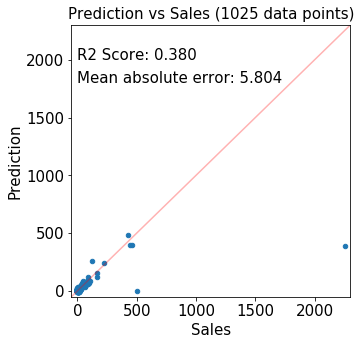

In [49]:
error_r2 = r2(df_evaluate['item_cnt'], df_evaluate['Prediction_shop'])
abs_error = measure_mae(df_evaluate['item_cnt'], df_evaluate['Prediction_shop'])

df_evaluate.plot.scatter(x='item_cnt', y='Prediction_shop', figsize=(5,5), fontsize=15)
plt.ylabel('Prediction',fontsize=15)
plt.xlabel('Sales',fontsize=15)
plt.xlim(-50,2300)
plt.ylim(-50,2300)
plt.text(1, 2000, "R2 Score: %.3f" % error_r2, size=15)
plt.text(1, 1800, "Mean absolute error: %.3f" % abs_error, size=15)
plt.title('Prediction vs Sales (%i data points)' % len(df_evaluate), fontsize=15)
plt.plot(xlim(), ylim(), ls="-", c='r', alpha=.3)
plt.show()

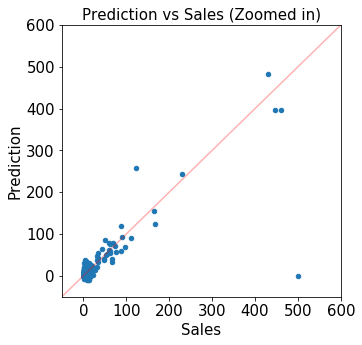

In [40]:
df_evaluate.plot.scatter(x='item_cnt', y='Prediction_shop', figsize=(5,5), fontsize=15)
plt.ylabel('Prediction',fontsize=15)
plt.xlabel('Sales',fontsize=15)
plt.xlim(-50,600)
plt.ylim(-50,600)
plt.title('Prediction vs Sales (Zoomed in)', fontsize=15)
plt.plot(xlim(), ylim(), ls="-", c='r', alpha=.3)
plt.show()

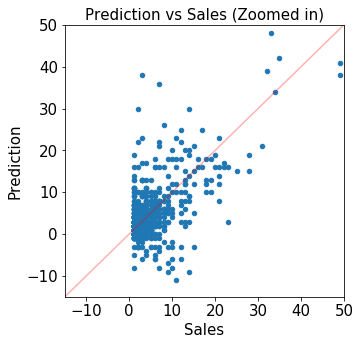

In [41]:
df_evaluate.plot.scatter(x='item_cnt', y='Prediction_shop', figsize=(5,5), fontsize=15)
plt.ylabel('Prediction',fontsize=15)
plt.xlabel('Sales',fontsize=15)
plt.xlim(-15,50)
plt.ylim(-15,50)
plt.title('Prediction vs Sales (Zoomed in)', fontsize=15)
plt.plot(xlim(), ylim(), ls="-", c='r', alpha=.3)
plt.show()